In [3]:
##### Import necessary library
import numpy as np
import matplotlib.pyplot as plt

***1. Rate Distortion Theory***

Given $P_X$, the distribution on $\mathscr{X}$. And we have cost function $d(x,y)$.

The condtional distribution is given by $W \in \mathscr{P}_{Y \mid X}$, where $\mathscr{P}_{Y \mid X, D}:= \{ W \in \mathscr{P}_{Y \mid X} \mid \sum_{x,y} P_X(x) W(y\mid x) d(x,y)=D \}$

We denote $W \times P_X(y,x) := W(y \mid x) P_X(x)$, and mutual information: $I(X;Y)_{W \times P_X} = \min_{Q_Y} D(W \times P_X || Q_Y \times P_X)$.

We aim to calculate minimum compression rate:

$ \min \{ I(X;Y)_{W \times P_X} \mid W \in \mathscr{P}_{Y \mid X,D}\} 
= \min_{W \in \mathscr{P}_{Y \mid X,D} } \min_{Q_Y} D(W \times P_X || Q_Y \times P_X)$


***2. EM Algorithm***

Consider the **EM algorithm** for solving the above minimum compression rate.

For m-projection, we have,

$Γ_{\mathscr{E}}^{(m)} [W^{(t)} \times P_X] (x,y) = W^{(t)}_{P_X} (y) P_X(x) = W^{(t)}_{P_X} \times P_X (x,y)$,

For e-projection, we have,

$Γ_{\mathscr{M}}^{(e)} [W^{(t)}_{P_X}  \times P_X] (x,y) = P_X(x) W^{(t)}_{P_X} (y) \exp (\theta_{*} d(x,y) ) \left( \sum_{y^{\prime}} W^{(t)}_{P_X} (y^{\prime}) \exp (\theta_{*} d(x,y^{\prime}) ) \right)^{-1}$,


$\theta_{*} := \arg \min_{\theta} \phi(\theta) - \theta D$

$\phi(\theta):= \sum_x P_X(x) \log \sum_y W^{(t)}_{P_X} (y) \exp(\theta d(x,y)) $

***3. Current Setting***

The current setting is given by (1) $\mathscr{X} = \{ x_1, x_2\}$, $\mathscr{Y} = \{ y_1, y_2\}$, (2) $P_X = (0.5, 0.5)^{\top}$, (3) $d(x,y) = [[0,1], [1,0]]$, i.e., $d=0$ when $x = y$, and (4) D = 0.4

In [4]:
##### Define parameters
P_X = np.array([0.5, 0.5]) # Distribution over X
d = np.array([[0, 1], 
              [1, 0]]) # Cost function
c = 0.4 # Distortion constraint
epsilon = 1e-6 # Convergence threshold
max_iter= 2000 # Maximum number of iterations

In [5]:
##### EM algorithm
def phi(theta, W, P_X, d):
    return np.sum(P_X * np.log(np.sum(W * np.exp(theta * d), axis=1)))

def e_projection(W, P_X, d, c):
    theta_low = -10
    theta_high = 10  # Binary search bounds for θ
    while theta_high - theta_low > epsilon:
        theta_mid = (theta_low + theta_high) / 2
        avg_distortion = np.sum(P_X * np.sum(W * d * np.exp(theta_mid * d), axis=1) / np.sum(W * np.exp(theta_mid * d), axis=1))
        if avg_distortion < c:
            theta_low = theta_mid
        else:
            theta_high = theta_mid
    theta_star = (theta_low + theta_high) / 2
    return W * np.exp(theta_star * d) / np.sum(W * np.exp(theta_star * d), axis=1, keepdims=True)

def m_projection(W, P_X):
    return np.sum(W * P_X[:, np.newaxis], axis=0) * P_X[:, np.newaxis]

In [6]:
##### Initialize W randomly
np.random.seed(128)
W = np.random.rand(2, 2)
W /= W.sum(axis=1, keepdims=True)

I_values = []
for t in range(max_iter):
    W_old = W.copy()
    W_P_X = m_projection(W, P_X) # M-projection
    W = e_projection(W_P_X, P_X, d, c) # E-projection
    I = np.sum(P_X[:, np.newaxis] * W * np.log(W / W.sum(axis=0, keepdims=True)))  # Compute mutual information
    I_values.append(I)
    if np.linalg.norm(W - W_old) < epsilon:
        break


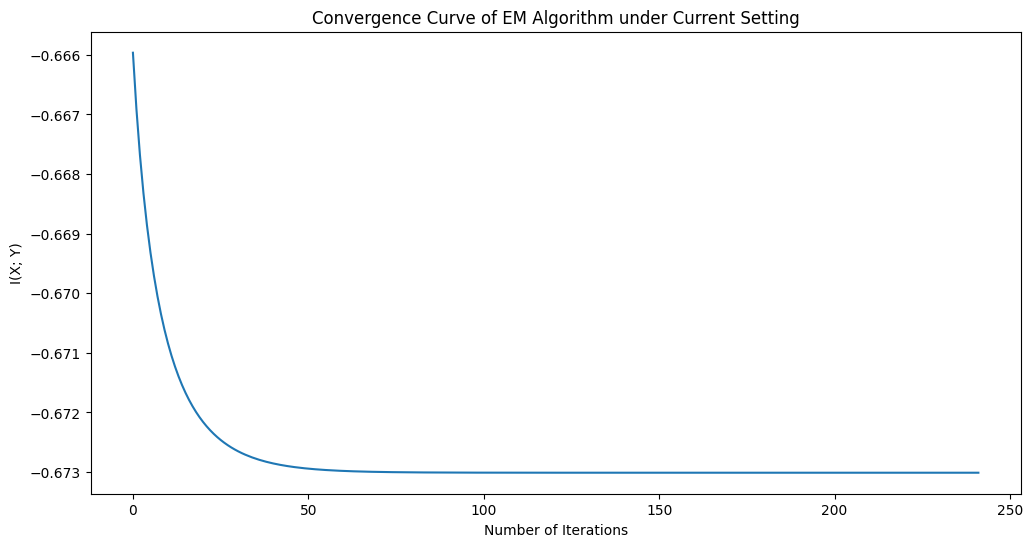

The optimal Mutual Information: -0.6730
The optimal W is [[0.6000117  0.3999883 ]
 [0.40001172 0.59998828]]


In [7]:
##### Plot convergence
plt.figure(figsize=(12, 6))
plt.plot(I_values)
plt.xlabel("Number of Iterations")
plt.ylabel("I(X; Y)")
plt.title("Convergence Curve of EM Algorithm under Current Setting")
plt.show()

##### Print final results
print(f"The optimal Mutual Information: {I_values[-1]:.4f}")
print("The optimal W is {}".format(W))